In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
url = '/content/drive/MyDrive/4238/'

In [ ]:
dataset_C = url + 'Dataset C.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [ ]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-c.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(24298, 2)


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [ ]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-c')

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  24298


# **Base Parameter**

In [ ]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

16


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:972
Test dataloader:243


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 2.3019356727600098. Accuracy: 10.146120600946697
Epoch:  2
Iteration: 1000. Loss: 2.301438570022583. Accuracy: 9.713932908005763
Iteration: 1500. Loss: 2.3012330532073975. Accuracy: 10.146120600946697
Epoch:  3
Iteration: 2000. Loss: 2.304161548614502. Accuracy: 9.528709611031076
Iteration: 2500. Loss: 2.2980141639709473. Accuracy: 9.713932908005763
Epoch:  4
Iteration: 3000. Loss: 2.2978148460388184. Accuracy: 9.713932908005763
Iteration: 3500. Loss: 2.305051326751709. Accuracy: 9.528709611031076
Epoch:  5
Iteration: 4000. Loss: 2.29624080657959. Accuracy: 9.569870343692118
Iteration: 4500. Loss: 2.30608868598938. Accuracy: 9.837415105988887
Epoch:  6
Iteration: 5000. Loss: 2.305593490600586. Accuracy: 9.569870343692118
Iteration: 5500. Loss: 2.307450532913208. Accuracy: 9.528709611031076
Epoch:  7
Iteration: 6000. Loss: 2.3075804710388184. Accuracy: 9.569870343692118
Iteration: 6500. Loss: 2.299804449081421. Accuracy: 9.713932908005763
Epoch:  8
Iterat

[2.3019356727600098, 2.301438570022583, 2.3012330532073975, 2.304161548614502, 2.2980141639709473, 2.2978148460388184, 2.305051326751709, 2.29624080657959, 2.30608868598938, 2.305593490600586, 2.307450532913208, 2.3075804710388184, 2.299804449081421, 2.308716058731079, 2.304563045501709, 2.3029587268829346, 2.300262689590454, 2.306171417236328, 2.301553964614868, 2.297191619873047, 2.2992615699768066, 2.295844554901123, 2.293837547302246, 2.2943637371063232, 2.3053228855133057, 2.294830799102783, 2.3002800941467285, 2.3057565689086914, 2.3021397590637207, 2.2961983680725098, 2.300797700881958]


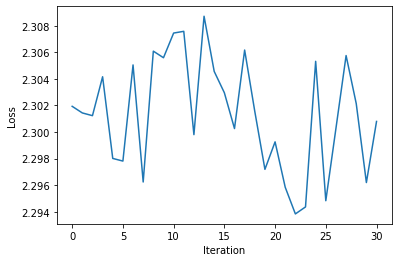

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# **1st Parameter**

In [ ]:
batch_size = 160
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

131


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:122
Test dataloader:31


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): Softmax(dim=0)
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Iteration: 500. Loss: 1.6117298603057861. Accuracy: 38.93805309734513
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Iteration: 1000. Loss: 1.1432063579559326. Accuracy: 53.01502366742128
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Iteration: 1500. Loss: 1.037680983543396. Accuracy: 62.15270631817246
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Iteration: 2000. Loss: 0.8669751286506653. Accuracy: 68.40913768265075
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Iteration: 2500. Loss: 0.5591330528259277. Accuracy: 70.40543321671126
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Iteration: 3000. Loss: 0.5442845821380615. Accuracy: 75.09775674006997
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Iteration: 3500. Loss: 0.3338839113712311. Accuracy: 78.28771352130067
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Iteration: 4000. Loss: 0.5489345788955688. Accuracy: 78.6993208479111
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Iteration: 4500. Loss: 0.412654727697

[1.6117298603057861, 1.1432063579559326, 1.037680983543396, 0.8669751286506653, 0.5591330528259277, 0.5442845821380615, 0.3338839113712311, 0.5489345788955688, 0.41265472769737244, 0.2468836009502411, 0.1804010272026062, 0.1250438690185547, 0.2040521800518036, 0.10789161920547485, 0.19459469616413116, 0.15866418182849884, 0.09031450748443604, 0.1335243433713913, 0.0745924562215805, 0.08135807514190674, 0.1534222513437271, 0.16261109709739685, 0.061255235224962234, 0.03375769406557083, 0.20473544299602509, 0.13307344913482666, 0.04723139479756355, 0.023771341890096664, 0.05689866468310356, 0.021396009251475334, 0.12976807355880737]


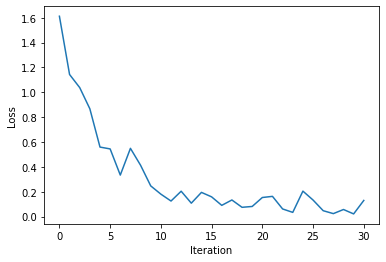

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# **2nd Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
url = '/content/drive/MyDrive/4238/'


In [ ]:
dataset_C = url + 'dataset_2_image.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [ ]:
PATH = '/content/'
train_data_labels = pd.read_csv('/content/csv/updatetrain.csv', usecols = ['filename', 'digit'])
test_data_labels = pd.read_csv('/content/csv/updatetest.csv', usecols = ['filename', 'digit'])
train_data_labels.head()

,filename,digit
0,0.jpg,9
1,1.jpg,0
2,2.jpg,0
3,3.jpg,3
4,4.jpg,0


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(train_data_labels, '/content/train', train_transform)
test_data = Dataset(test_data_labels, '/content/test_28', test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  60000


# **2nd Dataset**

In [ ]:
batch_size = 160
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

53


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:2400
Test dataloader:600


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1


IndexError: ignored